In [0]:
# !pip list

In [0]:
%%html
<marquee style='width: 50%; color: Green;'>It's a Kind of Magic!</marquee>

Heading
# Title
## Subtitle

>For this project, we will be working with the __Chest X-Ray Images (Pneumonia)__ dataset, from Kaggle [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The objective of the project is to build a deep neural network model that can classify whether a given patient has pneumonia, given a chest x-ray image.

        Acknowledgements
        Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

        License: CC BY 4.0

        Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


# Notebook Preparation

Import required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers, initializers, optimizers
from keras.optimizers import SGD
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

import random
from random import shuffle
from tqdm import tqdm  

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Verify the current working directory



In [3]:
import os
!pwd

/content


Let's get a sense of our directory structure.

In [4]:
# using Ipython magic to move to the `root` folder
%cd /root/

# viewing root subdirectories as a list
# subdirs = [x[0] for x in os.walk('.')]
# print(subdirs)

# viewing root subdirectories in a vertical orientation
#for x in os.walk('.'):
#    print(x[0])

/root


Create a `data` subdirectory and a hidden `.kaggle` directory for data download credentials.

In [5]:
# creating a directory for sample data
!mkdir ./data/

# creating a directory for data download credentials
!mkdir ~/.kaggle

# list items in the `content` directory
!ls

data


Verify the hidden directory, and move into it.

In [6]:
%cd ~/.kaggle/

/root/.kaggle


Upload your **Kaggle API key** to the current, hidden directory.

In [0]:
from google.colab import files
files.upload()

Verify the current directory and its contents.

In [8]:
!pwd
%ls

/root/.kaggle
kaggle.json


__Update permissions__ on the json file to readable and writeabile by the owner and not readable, writeable, or executable by anyone else.

>  Clear output from the `files.upload()` cell, above, before saving publicly the notebook.

In [0]:
!chmod 600 ./kaggle.json

Move to the `content/data` directory.

In [10]:
%cd ..
%cd data/

# viewing the current, `data` directory
%ls

/root
/root/data


# Obtain Data

>The dataset is provided in "3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal)."

Download the dataset to the current `data`directory.

In [11]:
# downloading the dataset into `content/data'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:34<00:00, 30.0MB/s]
100% 2.29G/2.29G [00:34<00:00, 71.6MB/s]


Verify download.

In [12]:
%ls

chest-xray-pneumonia.zip


Inflate the compressed files.

In [13]:
# extracting the zipped files and directories
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

>We now have a `chest_xray` folder with subdirectories for *training*, *validation*, and *test* data.


In [14]:
# verify directory contents
!ls

chest_xray  chest-xray-pneumonia.zip



>Data added to Google Colab projects get cleared at the close of each session, so we do not need to worry about removing the `chest-xray-pneumonia.zip` compressed file.

In [15]:
# viewing 1 level deep
print(os.listdir("/root/data/chest_xray/chest_xray"))

['val', '.DS_Store', 'train', 'test']


In [16]:
# viewing next level
print(os.listdir("/root/data/chest_xray/chest_xray/val/"))

['PNEUMONIA', 'NORMAL', '.DS_Store']


# Scrub

In [0]:
train_dir = "/root/data/chest_xray/chest_xray/train/"
train_normal = train_dir + 'NORMAL'
train_pneumonia = train_dir + 'PNEUMONIA'

val_dir = "/root/data/chest_xray/chest_xray/val/"
val_normal = val_dir + 'NORMAL'
val_pneumonia = val_dir + 'PNEUMONIA'

test_dir = "/root/data/chest_xray/chest_xray/test/"
test_normal = test_dir + 'NORMAL'
test_pneumonia = test_dir + 'PNEUMONIA'

In [18]:
# printing how many images we have in each directory
1
print('There are', len([f for f in os.listdir(
    train_normal) if f.endswith('.jpeg')]), 
'normal images in the training set\n')

print('There are', len([f for f in os.listdir(
    train_pneumonia) if f.endswith('.jpeg')]), 
'pneumonia images in the training set\n')

print('There are', len([f for f in os.listdir(
    val_normal) if f.endswith('.jpeg')]), 
'normal images in the validation set\n')

print('There are', len([f for f in os.listdir(
    val_pneumonia) if f.endswith('.jpeg')]), 
'pneumonia images in the validation set\n')

print('There are', len([f for f in os.listdir(
    test_normal) if f.endswith('.jpeg')]), 
'normal images in the test set\n')

print('There are', len([f for f in os.listdir(
    test_pneumonia) if f.endswith('.jpeg')]), 
'pneumonia images in the test set\n')

There are 1341 normal images in the training set

There are 3875 pneumonia images in the training set

There are 8 normal images in the validation set

There are 8 pneumonia images in the validation set

There are 234 normal images in the test set

There are 390 pneumonia images in the test set



>* Pneumonia images surpass the number of normal images nearly 3-fold, in the training data set.
* Altogether, there are more than 5000 training images, 16 validation images, and 624 test images.

# Explore and Model

In [0]:
# importing necessary libraries.
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

__Data Counts and Shapes__

__Standardize__ image data by dividing each matrix by 255 and resizing images to 150 x 150.

In [0]:
# instantiating rescaling generators tor train and val data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

__Reshape__ image data and labels

In [22]:
# generating training and validation data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Design Model 1
>Using Keras:
* Alternate convolutional and pooling layers
* Include later layers with a larger number of parameters in order to detect more abstract patterns
* Add final dense layers to add a classifier to the convolutional base
* Compile this model

In [0]:
# importing necessary libraries
from keras import layers
from keras import models
from keras import optimizers

In [0]:
# building the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [0]:
# importing keras modules
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [0]:
# creating a directory for saving models
!mkdir ./models/

In [0]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = f_path + 'my_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [31]:
# training and evaluating the model
# using the callback in the `model.fit`
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              callbacks = my_callbacks)

Epoch 1/30
100/100 [==============================] - 35s 351ms/step - loss: 0.4638 - acc: 0.8000 - val_loss: 1.1040 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.10395, saving model to ./models/my_model.h5
Epoch 2/30
100/100 [==============================] - 30s 296ms/step - loss: 0.2809 - acc: 0.8770 - val_loss: 0.7892 - val_acc: 0.6250

Epoch 00002: val_loss improved from 1.10395 to 0.78921, saving model to ./models/my_model.h5
Epoch 3/30
100/100 [==============================] - 29s 292ms/step - loss: 0.1913 - acc: 0.9198 - val_loss: 0.5219 - val_acc: 0.8125

Epoch 00003: val_loss improved from 0.78921 to 0.52190, saving model to ./models/my_model.h5
Epoch 4/30
100/100 [==============================] - 30s 296ms/step - loss: 0.1491 - acc: 0.9375 - val_loss: 0.6187 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.52190
Epoch 5/30
100/100 [==============================] - 29s 289ms/step - loss: 0.1225 - acc: 0.9544 - val_loss: 0.8189 - val_acc: 0.

In [0]:
# download the model
files.download('./models/my_model.h5')

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

__Visualize Training Results__

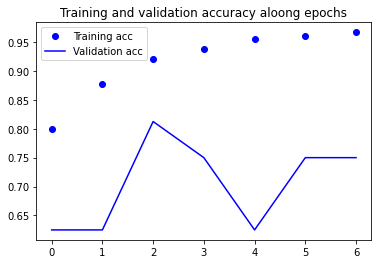

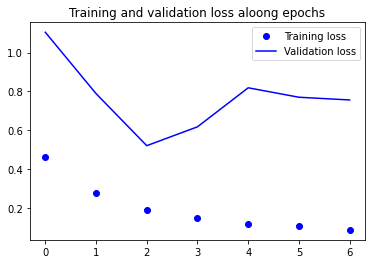

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy aloong epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss aloong epochs')
plt.legend()
plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.6447317004203796
val acc: 0.625


### Data Augmentation

__Load the Saved Model__

In [0]:
# loading the saved models
# from keras.models import load_model

# my_model = load_model(filePath + 'my_model.h5', 
#         custom_objects={'loss':balanced_cross_entropy(0.20)})

In [38]:
train_datagen = ImageDataGenerator(rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=32, 
                                                        class_mode='binary')
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=100, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              callbacks = my_callbacks)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 59s 587ms/step - loss: 112.7674 - acc: 0.7538 - val_loss: 0.4312 - val_acc: 0.7500

Epoch 00001: val_loss improved from 0.52190 to 0.43124, saving model to ./models/my_model.h5
Epoch 2/100
100/100 [==============================] - 53s 532ms/step - loss: 34.0307 - acc: 0.7606 - val_loss: 0.5152 - val_acc: 0.7500

Epoch 00002: val_loss did not improve from 0.43124
Epoch 3/100
100/100 [==============================] - 54s 536ms/step - loss: 15.3761 - acc: 0.7794 - val_loss: 0.5769 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.43124
Epoch 4/100
100/100 [==============================] - 54s 537ms/step - loss: 7.9124 - acc: 0.7853 - val_loss: 0.6189 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.43124
Epoch 5/100
100/100 [==============================] - 53s 531ms/step - loss: 4.6107 - acc: 0.7922 - val_loss: 0.6447 - 

In [39]:
# download the model
files.download('./models/my_model.h5')

# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

Visualize Results

In [44]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.6447317004203796
val acc: 0.625


> No significant change

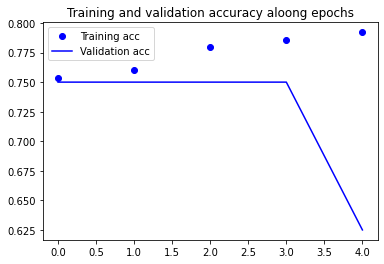

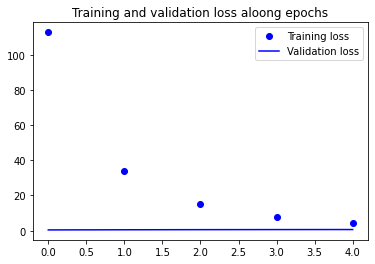

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy aloong epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss aloong epochs')
plt.legend()
plt.show()

### Evaluate Model 1 on Test Data

In [45]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.6201069355010986
test acc: 0.7855691313743591


> So the first model, with augmentation, has achieved __78.56\%__ accuracy predicting the class ('normal' or 'pneumonia' of our test set.

## Model 2

* add padding to input layer
* add dropout layers after each pooling layer

In [0]:
# building the a 2nd CNN model
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                        input_shape=(150, 150, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(layers.Flatten() )# this converts 3D feature maps to 1D vectors
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

* Change the optimizer to `Adam`
* use 'accuracy' metrics

In [0]:
# compiling the model
model_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [0]:
# importing keras modules
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [0]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = f_path + 'my_model_2.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [55]:
# training and evaluating the model
# using the callback in the `model.fit`
history_2 = model_2.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              callbacks = my_callbacks)

Epoch 1/30
100/100 [==============================] - 59s 590ms/step - loss: 1.2394 - acc: 0.6716 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69313, saving model to ./models/my_model_2.h5
Epoch 2/30
100/100 [==============================] - 55s 547ms/step - loss: 0.6276 - acc: 0.7153 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69313 to 0.69311, saving model to ./models/my_model_2.h5
Epoch 3/30
100/100 [==============================] - 54s 545ms/step - loss: 0.6060 - acc: 0.7306 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69311
Epoch 4/30
100/100 [==============================] - 54s 545ms/step - loss: 0.6041 - acc: 0.7325 - val_loss: 0.6933 - val_acc: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00004: val_loss did not improve from 0.69311
Epoch 5/30
100/100 [==============================] - 54s 540ms/step - loss: 0.5678 - acc: 0.7500 - val

In [0]:
# download the model
files.download('./models/my_model_2.h5')

In [58]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)      

__Visualize Training Results__

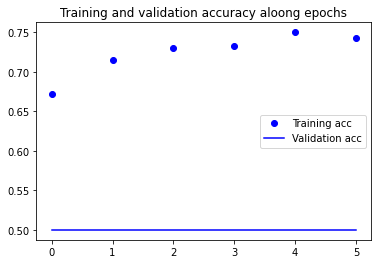

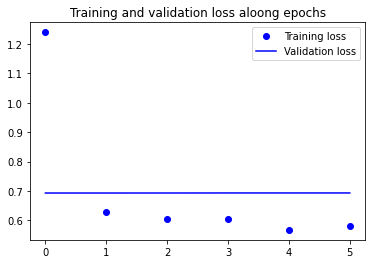

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy aloong epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

In [60]:
val_loss, val_acc = model_2.evaluate_generator(validation_generator, 
                                               steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.6933436393737793
val acc: 0.5


> Early stopping may have been a bit premature, for this model, as measures do not appear to have settled into a definitive trend.

### Evaluate Model 2 on Test Data

In [89]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model_2.evaluate_generator(test_generator, steps=50)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.6874414682388306
test acc: 0.6219512224197388


>The second model performed poorly, with a test set prediction accuracy score ~__16\%__ lower than the first model.

## Model 3

* trying fewer layers and fewer dropouts
* add dropout layers after each pooling layer

In [0]:
# building the a 2nd CNN model
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                        input_shape=(150, 150, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(Dropout(0.25))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten() )# this converts 3D feature maps to 1D vectors
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

* Change the optimizer to `Adam`
* use 'accuracy' metrics

In [0]:
# compiling the model
model_3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [0]:
# importing keras modules
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [0]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = f_path + 'my_model_3.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [69]:
# training and evaluating the model
# using the callback in the `model.fit`
history_3 = model_3.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              callbacks = my_callbacks)

Epoch 1/30
100/100 [==============================] - 60s 599ms/step - loss: 19.1501 - acc: 0.6778 - val_loss: 0.6923 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69229, saving model to ./models/my_model_3.h5
Epoch 2/30
100/100 [==============================] - 54s 537ms/step - loss: 0.6664 - acc: 0.7419 - val_loss: 0.6921 - val_acc: 0.5625

Epoch 00002: val_loss improved from 0.69229 to 0.69207, saving model to ./models/my_model_3.h5
Epoch 3/30
100/100 [==============================] - 53s 531ms/step - loss: 0.5460 - acc: 0.7638 - val_loss: 0.6920 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69207 to 0.69201, saving model to ./models/my_model_3.h5
Epoch 4/30
100/100 [==============================] - 54s 540ms/step - loss: 0.4931 - acc: 0.7831 - val_loss: 0.6922 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.69201
Epoch 5/30
100/100 [==============================] - 53s 529ms/step - loss: 0.4598 - acc: 0.7950 - val_loss: 0.6919 - val_

In [70]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)      

__Visualize Training Results__

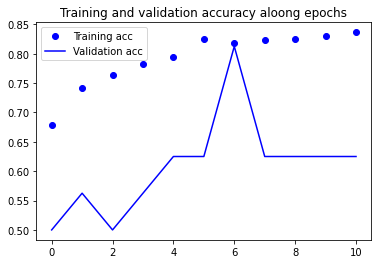

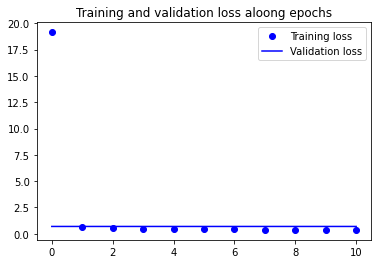

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy aloong epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss aloong epochs')
plt.legend()
plt.show()

In [72]:
# download the model
files.download('./models/my_model_3.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 53210, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [74]:
val_loss, val_acc = model_3.evaluate_generator(validation_generator, 
                                               steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.6920739412307739
val acc: 0.625


> Validation loss is similar to the second model, while validation acuracy is improved by ~ 12\%.

### Evaluate Model 3 on Test Data

In [75]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model_3.evaluate_generator(test_generator, steps=50)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.692423939704895
test acc: 0.6087398529052734


>The accuracy score for test data is even lower than that of the second model.

# Select a Final Model

> It turns out that our best performing model was our first augmented model, with RMSprop optimization.

In [90]:
# evaluating the best model on test data
# setting steps to 39 and batch_size to 16 (for 624 images)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=16, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.5929365158081055
test acc: 0.7868589758872986


* We can use this model as a basis for further tuning, or distribute the model as - is.
* A potential approach would be to perform a gridsearch on the optimizer, to determine best parameters.
* We could also adjust early stopping parameters, to see whether we will find benefit from more extensive training.

## Distribution

Since we previously saved our `my_model.h5` model, we can distribute it and use it on another system or for another project, as follows.

In [95]:
# loading the saved model
from keras.models import load_model

filepath = '/root/data/models/my_model.h5' # current path to saved file

dist_model = load_model(filepath, 
         custom_objects={'loss':'binary_crossentropy'})

dist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [96]:
# viewing 
loss, acc = dist_model.evaluate_generator(test_generator, steps=39)
print("Restored model, accuracy: {:5.2f}%)".format(100*acc))

Restored model, accuracy: 86.54%)


> Somehow, the restored model reports an even better performance than we realized when it was first run (__86.54\%__ vs. __78.69\%__). The only apparent difference is that we used 39 steps to evaluate the reloaded model, where we originally had used 50 steps.
>
>Let's re - check the distributed model against the test data.

In [97]:
# evaluating the distributed model on test data
# setting steps to 39 and batch_size to 16 (for 624 images)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=16, 
                                                  class_mode='binary')

test_loss, test_acc = dist_model.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.48552703857421875
test acc: 0.8653846383094788


### Optimization

# Summary